# Assignment 3 - SMAI - DoubleMNIST and PermutedMnist

In [2]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files


In [3]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import glob
import cv2
import scipy
import scipy.io
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import wandb
import yaml

from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.utils.data import random_split

import torchvision
from torchvision import transforms

In [5]:
from src_torch import *
from src_torch.classifiers import *

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: vanshg. Use `wandb login --relogin` to force relogin


True

## (5.1) Multi-digit Recognition on Multi-MNIST Dataset

### (5.1.0) Data Loading, Preprocessing and Visualization

In [8]:
DOUBLE_MNIST_FOLDER = os.path.join(DATA_FOLDER, "DOUBLE_MNIST")

train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

forbidden_labels = [11 * i for i in range(10)]

# Saving path of all images in train set
for img_folder in glob.glob(os.path.join(DOUBLE_MNIST_FOLDER, "train/*")):
    label = int(os.path.basename(img_folder))
    if label in forbidden_labels:
        continue
    for img_file in glob.glob(os.path.join(img_folder, "*")):
        image = torchvision.io.read_image(img_file)
        train_labels.append(label)
        train_images.append(image)

# Saving path of all images in val set
for img_folder in glob.glob(os.path.join(DOUBLE_MNIST_FOLDER, "val/*")):
    label = int(os.path.basename(img_folder))
    if label in forbidden_labels:
        continue
    for img_file in glob.glob(os.path.join(img_folder, "*")):
        image = torchvision.io.read_image(img_file)
        val_labels.append(label)
        val_images.append(image)

# Saving path of all images in test set
for img_folder in glob.glob(os.path.join(DOUBLE_MNIST_FOLDER, "test/*")):
    label = int(os.path.basename(img_folder))
    if label in forbidden_labels:
        continue
    for img_file in glob.glob(os.path.join(img_folder, "*")):
        image = torchvision.io.read_image(img_file)
        test_labels.append(label)
        test_images.append(image)

train_images = torch.stack(train_images, dim=0)
val_images = torch.stack(val_images, dim=0)
test_images = torch.stack(test_images, dim=0)

print(f"Shape of Training data: {train_images.shape}")
print(f"Shape of Validation data: {val_images.shape}")
print(f"Shape of Testing Data: {test_images.shape}")

Shape of Training data: torch.Size([58000, 1, 64, 64])
Shape of Validation data: torch.Size([14000, 1, 64, 64])
Shape of Testing Data: torch.Size([18000, 1, 64, 64])


In [9]:
# Pre-processing and creating a Pytorch Tensor Dataset
def convert_to_onehot(label):
    one_hot_label = torch.zeros(10)
    first_digit = label % 10
    one_hot_label[first_digit] = 1.0
    label = label // 10
    if label:
        second_digit = label % 10
        one_hot_label[second_digit] = 1.0
    else:
        one_hot_label[0] = 1.0
    
    return one_hot_label

def onehot_to_number(onehot_label):
    number = 0
    for i, num in enumerate(onehot_label[1:]):
        if num:
            number = number * 10 + num *  (i + 1)
    
    if onehot_label[0]:
        number = number * 10
    
    return int(number)

train_dataset = DoubleMNIST(train_images, train_labels, target_transform=convert_to_onehot)
val_dataset = DoubleMNIST(val_images, val_labels, target_transform=convert_to_onehot)
test_dataset = DoubleMNIST(test_images, test_labels, target_transform=convert_to_onehot)

In [10]:
y_values = []
for x, y in train_dataset:
    y_values.append(onehot_to_number(y))

y_values = torch.tensor(y_values)
train_classes = torch.unique(y_values)
print(train_classes)

tensor([10, 12, 13, 14, 15, 16, 18, 19, 20, 23, 24, 26, 27, 28, 29, 30, 34, 35,
        36, 37, 38, 40, 45, 47, 48, 49, 50, 56, 57, 58, 59, 60, 67, 69, 70, 78,
        79, 80, 89, 90])


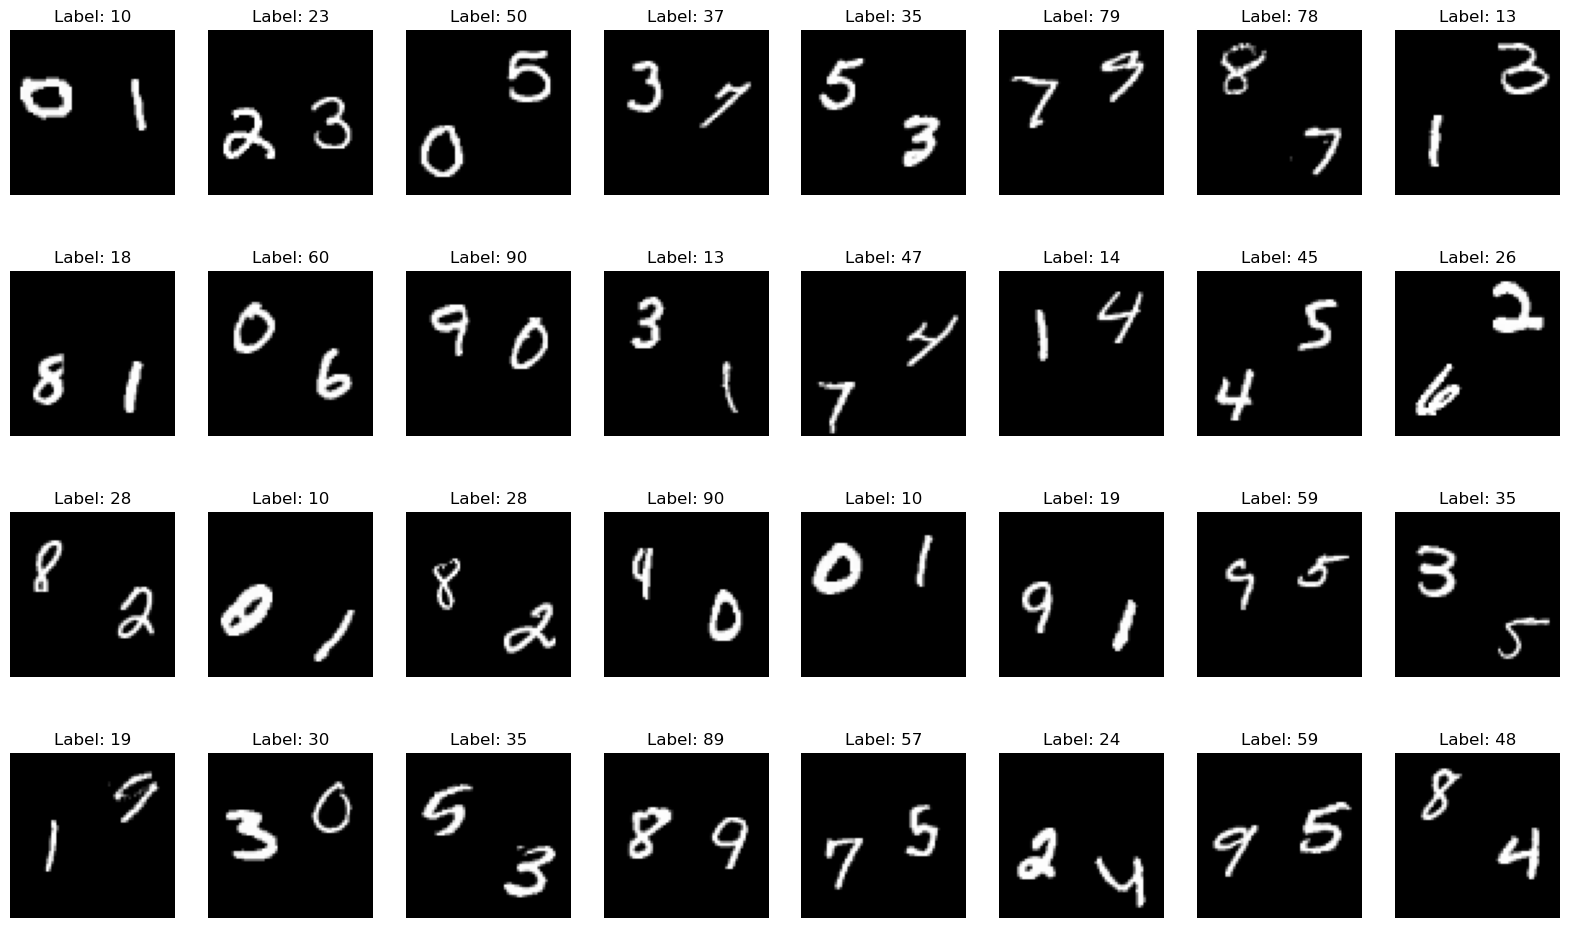

In [11]:
# Visualizing Images
num_display = 32
indices = np.random.choice(np.arange(len(train_dataset)), num_display)

plots_per_row = 8
num_rows = num_display // plots_per_row
if num_display % plots_per_row:
    num_rows += 1

fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(20, 12))
axs = axs.flatten()

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]
    label = onehot_to_number(label)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
    axs[i].imshow(image.squeeze(), cmap='gray')

plt.show()

### (5.1.1) MLP on DoubleMnist

In [47]:
torch.manual_seed(42)
mlp_model = SimpleMLP(input_dim=64*64, hidden_dims=[1024], num_classes=10, flatten_first=True)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

train_config = {
    "device": device,
    "epochs": 20,
    "print_every": 250,
    "argmax": False
}

_ = train(mlp_model, criterion, optimizer, train_dataset, val_dataset, **train_config)


Model is on device: cuda

Number of Iterations Per Epoch: 580
Iteration: 1/11600 | loss = 0.6960338950157166
Iteration: 250/11600 | loss = 0.392140656709671
Iteration: 500/11600 | loss = 0.3577534258365631
Epoch: 1 | Train Accuracy: 9.293 | Val Accuracy: 1.400|  Train loss: 0.3394 | Val loss: 0.4802

Iteration: 750/11600 | loss = 0.353179007768631
Iteration: 1000/11600 | loss = 0.3120650351047516
Epoch: 2 | Train Accuracy: 16.603 | Val Accuracy: 2.986|  Train loss: 0.2872 | Val loss: 0.4918

Iteration: 1250/11600 | loss = 0.27855196595191956
Iteration: 1500/11600 | loss = 0.2803225815296173
Epoch: 3 | Train Accuracy: 19.617 | Val Accuracy: 3.271|  Train loss: 0.2646 | Val loss: 0.4936

Iteration: 1750/11600 | loss = 0.25538334250450134
Iteration: 2000/11600 | loss = 0.29189175367355347
Iteration: 2250/11600 | loss = 0.2749367356300354
Epoch: 4 | Train Accuracy: 24.083 | Val Accuracy: 3.064|  Train loss: 0.2462 | Val loss: 0.4991

Iteration: 2500/11600 | loss = 0.22842666506767273
Iter

In [13]:
eval_config = {
    "device": device,
    "argmax": False
}

test_acc, test_loss = evaluate(mlp_model, test_dataset, **eval_config)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 4.5778 | Test Loss: 4.2048


#### (5.1.1.2) - Hyper-parameter Tuning with Wandb

In [32]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "BCE",
        "model": {
            "input_dim":64*64,
            "num_layers": 1,
            "hidden_dims1": 1024,
            "num_classes": 10,
            "last_activation": "sigmoid",
            "flatten_first": True
        },
        "optimizer": {
            "learning_rate": 0.01,
        },
        "training": {
            "batch_size": 128,
            "epochs": 10,
            "print_every": 100,
            # "log_wandb": True,
            "verbose": True,
            "print_every": 250,
            "argmax": False
        }
    }
}

model = trigger_training(config["parameters"], train_dataset, val_dataset)

Model Type: MLP
SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
    (3): Sigmoid()
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 454
Iteration: 1/4540 | loss = 0.6962
Iteration: 250/4540 | loss = 0.3965
Epoch: 1 | Train Accuracy: 11.938 | Val Accuracy: 2.907|  Train loss: 15.1309 | Val loss: 17.5471

Iteration: 500/4540 | loss = 0.3559
Iteration: 750/4540 | loss = 0.3330
Epoch: 2 | Train Accuracy: 19.728 | Val Accuracy: 5.964|  Train loss: 12.5688 | Val loss: 16.5821

Iteration: 1000/4540 | loss = 0.3070
Iteration: 1250/4540 | loss = 0.3168
Epoch: 3 | Train Accuracy: 23.967 | Val Accuracy: 6.229|  Train loss: 11.6688 | Val loss: 16.8943

Iteration: 1500/4540 | loss = 0.2961
Iteration: 1750/4540 | loss = 0.2949
Epoch: 4 | Train Accuracy: 27.338 | Val Accuracy: 6.293|  Train loss: 11.1791 | Val loss: 16.7679

Iteration: 2000/4540 | loss = 0.

In [10]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))

    # setting the wandb run name for the current config
    model_type = get_model_type(config["model"])
    if model_type == "CNN":
        run_name = make_wandb_run_name_cnn(config)
    elif model_type == "MLP":
        run_name = make_wandb_run_name_mlp(config)
    else:
        return
    print(f"Run Name: {run_name}")
    run.name = run_name

    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [11]:
f = open(os.path.join(YAML_FOLDER, "task-5.1/multi-mnist-single-layer.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task5', 'name': 'multi-mnist-single-layer', 'parameters': {'criterion': {'value': 'BCELogits'}, 'model.input_dim': {'value': 4096}, 'model.num_layers': {'value': 1}, 'model.hidden_dims1': {'values': [2048, 1024, 512]}, 'model.num_classes': {'value': 10}, 'model.flatten_first': {'value': True}, 'optimizer.learning_rate': {'values': [0.001, 0.0005, 0.01]}, 'training.batch_size': {'values': [64, 128]}, 'training.epochs': {'value': 10}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 250}, 'training.argmax': {'value': False}}}


In [12]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task5.1")

Create sweep with ID: 88xv7kxf
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task5.1/sweeps/88xv7kxf


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

### (5.1.2) CNN on DoubleMnist

In [14]:
# Best Hyper-parameters found using Wandb
torch.manual_seed(42)
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "BCELogits",
        "model": {
            "input_dim": 64,
            "conv_layers": 2,
            "num_channels": 32,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.25,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 0.001,
        },
        "training": {
            "batch_size": 64,
            "epochs": 19,
            "argmax": False,
            "print_every": 100,
            "verbose": True
        }
    }
}

best_cnn_double_mnist = trigger_training(config["parameters"], train_dataset, val_dataset)

Model Type: CNN
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=16384, out_features=10, bias=True)
)
BCEWithLogitsLoss()

Model is on device: cuda

Number of Iterations Per Epoch: 907


Iteration: 1/17233 | loss = 0.6932
Iteration: 100/17233 | loss = 0.4393
Iteration: 200/17233 | loss = 0.3147
Iteration: 300/17233 | loss = 0.2511
Iteration: 400/17233 | loss = 0.2158
Iteration: 500/17233 | loss = 0.1622
Iteration: 600/17233 | loss = 0.1311
Iteration: 700/17233 | loss = 0.1085
Iteration: 800/17233 | loss = 0.1421
Iteration: 900/17233 | loss = 0.1072
Epoch: 1 | Train Accuracy: 68.514 | Val Accuracy: 35.486|  Train loss: 0.0911 | Val loss: 0.2009

Iteration: 1000/17233 | loss = 0.0938
Iteration: 1100/17233 | loss = 0.1324
Iteration: 1200/17233 | loss = 0.0890
Iteration: 1300/17233 | loss = 0.1245
Iteration: 1400/17233 | loss = 0.1118
Iteration: 1500/17233 | loss = 0.1129
Iteration: 1600/17233 | loss = 0.0740
Iteration: 1700/17233 | loss = 0.0722
Iteration: 1800/17233 | loss = 0.0588
Epoch: 2 | Train Accuracy: 81.424 | Val Accuracy: 48.536|  Train loss: 0.0559 | Val loss: 0.1565

Iteration: 1900/17233 | loss = 0.0711
Iteration: 2000/17233 | loss = 0.0665
Iteration: 2100/17

#### (5.1.2.4) Evaluating CNN on Test Set

In [15]:
eval_config = {
    "device": device,
    "argmax": False,
    "criterion": nn.BCEWithLogitsLoss(),
}

test_acc, test_loss = evaluate(best_cnn_double_mnist, test_dataset, **eval_config)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 58.6667 | Test Loss: 0.2100


#### (5.1.2.2) - Hyper-parameter Tuning with Wandb

In [98]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))

    # setting the wandb run name for the current config
    model_type = get_model_type(config["model"])
    if model_type == "CNN":
        run_name = make_wandb_run_name_cnn(config)
    elif model_type == "MLP":
        run_name = make_wandb_run_name_mlp(config)
    else:
        return
    print(f"Run Name: {run_name}")
    run.name = run_name

    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [102]:
f = open(os.path.join(YAML_FOLDER, "task-5.1/multi-mnist-two-conv-layers.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task5.1', 'name': 'multi-mnist-two-conv-layers', 'parameters': {'criterion': {'value': 'BCELogits'}, 'model.input_dim': {'value': 64}, 'model.conv_layers': {'value': 2}, 'model.num_channels': {'values': [32, 16, 8]}, 'model.kernel_size': {'values': [5, 3]}, 'model.stride': {'values': [1]}, 'model.dropout': {'values': [0.25, 0.1, 0]}, 'model.num_classes': {'value': 10}, 'optimizer.learning_rate': {'values': [0.001, 0.0005, 0.01]}, 'training.batch_size': {'values': [128, 64]}, 'training.epochs': {'value': 20}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 100}, 'training.argmax': {'value': False}}}


In [103]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task5.1")

Create sweep with ID: grfpsnh3
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task5.1/sweeps/grfpsnh3


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

### (5.1.3) Testing on Single Digit MNIST

In [24]:
# Loading the Single Digit MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(18)
])

single_mnist_test = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=False,
    transform=transform, target_transform=convert_to_onehot,
    download=True
)

print(f"Size of Test Dataset: {len(single_mnist_test)}")
print(f"Size of images: {single_mnist_test[0][0].shape}")
print(f"Size of Labels: {single_mnist_test[0][1].shape}")

Size of Test Dataset: 10000
Size of images: torch.Size([1, 64, 64])
Size of Labels: torch.Size([10])


In [26]:
# Accuracy and Loss on Single Digit Mnist Dataset
eval_config = {
    "device": device,
    "argmax": False,
    "criterion": nn.BCEWithLogitsLoss(),
}

test_acc, test_loss = evaluate(best_cnn_double_mnist, single_mnist_test, **eval_config)
print(f"Single Digit Mnist Test Accuracy: {test_acc*100:.4f} | Single Digit Mnist Test Loss: {test_loss:.4f}")

Single Digit Mnist Test Accuracy: 5.3200 | Single Digit Mnist Test Loss: 1.3419


## (5.2) - Permuted MNIST

### (5.2.0) Data Loading, PreProcessing and Visualizing

In [7]:
PERMUTED_MNIST_FILE = os.path.join(DATA_FOLDER, "permuted_mnist.npz")

data = np.load(PERMUTED_MNIST_FILE)

train_images = torch.tensor(data['train_images'])/255.0
train_images = train_images.unsqueeze(1)
train_labels = torch.tensor(data['train_labels'])
test_images = torch.tensor(data['test_images'])/255.0
test_images = test_images.unsqueeze(1)
test_labels = torch.tensor(data['test_labels'])

complete_train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


#### Splitting into Train/Val Data

In [8]:
val_ratio = 0.3
val_size = int(val_ratio * len(complete_train_dataset))
train_size = len(complete_train_dataset) - val_size

train_dataset, val_dataset = random_split(complete_train_dataset, [train_size, val_size])

print(f"Length of Training Data: {len(train_dataset)}")
print(f"Length of Validation Data: {len(val_dataset)}")
print(f"Length of Testing Data: {len(test_dataset)}")

Length of Training Data: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


### (5.2.1) - MLP on Permuted MNIST

In [9]:
model_config = {
    "input_dim": 28*28,
    "hidden_dims": [],
    "num_classes": 10,
    "flatten_first": True
}

mlp_model = SimpleMLP(**model_config)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

print(mlp_model)

train_config = {
    "device": device,
    "print_every": 100
}

_ = train(mlp_model, criterion, optimizer, train_dataset, val_dataset, **train_config)

SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 420
Iteration: 1/4200 | loss = 2.3044
Iteration: 100/4200 | loss = 0.4677
Iteration: 200/4200 | loss = 0.2488
Iteration: 300/4200 | loss = 0.1896
Iteration: 400/4200 | loss = 0.3136
Epoch: 1 | Train Accuracy: 92.107 | Val Accuracy: 91.600|  Train loss: 0.2865 | Val loss: 0.3030

Iteration: 500/4200 | loss = 0.2994
Iteration: 600/4200 | loss = 0.2329
Iteration: 700/4200 | loss = 0.3318
Iteration: 800/4200 | loss = 0.1789
Epoch: 2 | Train Accuracy: 91.771 | Val Accuracy: 90.844|  Train loss: 0.2837 | Val loss: 0.3090

Iteration: 900/4200 | loss = 0.2744
Iteration: 1000/4200 | loss = 0.3343
Iteration: 1100/4200 | loss = 0.2791
Iteration: 1200/4200 | loss = 0.2781
Epoch: 3 | Train Accuracy: 92.374 | Val Accuracy: 91.461|  Train loss: 0.2692 | Val loss: 0.3075

Iteration: 1300/4200 | loss = 0.1850
Iteration: 1400/4200 | loss = 0.34

In [30]:
# Testing performance on Test Dataset
test_acc, test_loss = evaluate(mlp_model, test_dataset, device=device)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 91.8700 | Test Loss: 0.3127


#### (5.2.1.2) Hyperparameter Tuning with Wandb

In [ ]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "input_dim":28*28,
            "num_layers": 1,
            "hidden_dims1": 2048,
            "num_classes": 10,
            "flatten_first": True
        },
        "optimizer": {
            "learning_rate": 0.01,
        },
        "training": {
            "batch_size": 128,
            "epochs": 10,
            "print_every": 100,
            # "log_wandb": True,
            "verbose": True,
            "print_every": 250,
        }
    }
}

model = trigger_training(config["parameters"], train_dataset, val_dataset)

In [17]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))

    # setting the wandb run name for the current config
    model_type = get_model_type(config["model"])
    if model_type == "CNN":
        run_name = make_wandb_run_name_cnn(config)
    elif model_type == "MLP":
        run_name = make_wandb_run_name_mlp(config)
    else:
        return
    print(f"Run Name: {run_name}")
    run.name = run_name

    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [25]:
f = open(os.path.join(YAML_FOLDER, "task-5.1.2/permuted-mnist-single-layer.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task5', 'name': 'permuted-mnist-single-layer', 'parameters': {'criterion': {'value': 'CE'}, 'model.input_dim': {'value': 784}, 'model.num_layers': {'value': 1}, 'model.hidden_dims1': {'values': [1024, 512, 256]}, 'model.num_classes': {'value': 10}, 'model.flatten_first': {'value': True}, 'optimizer.learning_rate': {'values': [0.01, 0.001, 0.0005]}, 'training.batch_size': {'values': [64, 128, 256]}, 'training.epochs': {'value': 10}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 250}}}


In [26]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task5")

Create sweep with ID: kr42ue6x
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task5/sweeps/kr42ue6x


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

wandb: Agent Starting Run: rx7h1i0g with config:
wandb: 	criterion: CE
wandb: 	model.flatten_first: True
wandb: 	model.hidden_dims1: 1024
wandb: 	model.input_dim: 784
wandb: 	model.num_classes: 10
wandb: 	model.num_layers: 1
wandb: 	optimizer.learning_rate: 0.01
wandb: 	training.batch_size: 64
wandb: 	training.epochs: 10
wandb: 	training.log_wandb: True
wandb: 	training.print_every: 250
wandb: 	training.verbose: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: H1024-lr0.01-batch64
Model Type: MLP
SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 657
Iteration: 1/6570 | loss = 2.2978
Iteration: 250/6570 | loss = 0.2229
Iteration: 500/6570 | loss = 0.0947
Epoch: 1 | Train Accuracy: 95.890 | Val Accuracy: 94.844|  Train loss: 0.1382 | Val loss: 0.1929

Iteration: 750/6570 | loss = 0.2264
Iteration: 1000/6570 | loss = 0.0503
Iteration: 1250/6570 | loss = 0.0982
Epoch: 2 | Train Accuracy: 96.243 | Val Accuracy: 94.822|  Train loss: 0.1389 | Val loss: 0.2290

Iteration: 1500/6570 | loss = 0.1171
Iteration: 1750/6570 | loss = 0.1380
Epoch: 3 | Train Accuracy: 98.136 | Val Accuracy: 96.378|  Train loss: 0.0665 | Val loss: 0.1592

Iteration: 2000/6570 | loss = 0.1707
Iteration: 2250/6570 | loss = 0.0130
Iteration: 2500/6570 | loss = 0.0051
Epoch: 4 | T

wandb: Ctrl + C detected. Stopping sweep.


best_epoch,▁
best_val_acc,▁
best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▇▆▇▅███▇
train_loss,██▃▃▂▄▁▁▁▄
val_acc,▁▁█▆▇▅███▆
val_loss,▂▄▁▃▃▄▃▄▄█
best_epoch,7
best_val_acc,0.964
best_val_loss,0.20768


### (5.2.2) CNN on Permuted MNIST

In [10]:
cnn_model = SimpleCNN(kernel_size=5, num_channels=128, stride=1, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

train_config = {
    "device": device,
    "print_every": 100
}

_ = train(cnn_model, criterion, optimizer, train_dataset, val_dataset, **train_config)


Model is on device: cuda

Number of Iterations Per Epoch: 420


Iteration: 1/4200 | loss = 2.2936
Iteration: 100/4200 | loss = 0.5255
Iteration: 200/4200 | loss = 0.3674
Iteration: 300/4200 | loss = 0.2020
Iteration: 400/4200 | loss = 0.3121
Epoch: 1 | Train Accuracy: 93.924 | Val Accuracy: 92.917|  Train loss: 0.1974 | Val loss: 0.2287

Iteration: 500/4200 | loss = 0.2596
Iteration: 600/4200 | loss = 0.1675
Iteration: 700/4200 | loss = 0.3777
Iteration: 800/4200 | loss = 0.4231
Epoch: 2 | Train Accuracy: 94.250 | Val Accuracy: 92.867|  Train loss: 0.1790 | Val loss: 0.2258

Iteration: 900/4200 | loss = 0.2809
Iteration: 1000/4200 | loss = 0.1896
Iteration: 1100/4200 | loss = 0.2677
Iteration: 1200/4200 | loss = 0.2256
Epoch: 3 | Train Accuracy: 95.355 | Val Accuracy: 93.706|  Train loss: 0.1491 | Val loss: 0.2142

Iteration: 1300/4200 | loss = 0.3346
Iteration: 1400/4200 | loss = 0.3543
Iteration: 1500/4200 | loss = 0.1842
Iteration: 1600/4200 | loss = 0.1868
Epoch: 4 | Train Accuracy: 95.100 | Val Accuracy: 93.489|  Train loss: 0.1730 | Val loss:

In [14]:
test_acc, test_loss = evaluate(cnn_model, test_dataset, device=device)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 94.0400 | Test Loss: 0.2229


#### (5.2.2.2) Hyperparameter Tuning with Wandb

In [21]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "input_dim": 28,
            "conv_layers": 2,
            "num_channels": 128,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 0.01,
        },
        "training": {
            "batch_size": 100,
            "epochs": 10,
            "print_every": 100,
            # "log_wandb": True,
            "verbose": True
        }
    }
}

model = trigger_training(config["parameters"], train_dataset, val_dataset)

Model Type: CNN
SimpleCNN(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)

Model is on device: cuda

Number of Iterations Per Epoch: 420


Iteration: 1/4200 | loss = 2.3129
Iteration: 100/4200 | loss = 0.4289
Iteration: 200/4200 | loss = 0.1083
Iteration: 300/4200 | loss = 0.3153
Iteration: 400/4200 | loss = 0.0704
Epoch: 1 | Train Accuracy: 94.367 | Val Accuracy: 93.294|  Train loss: 0.1789 | Val loss: 0.2143

Iteration: 500/4200 | loss = 0.3283
Iteration: 600/4200 | loss = 0.2205
Iteration: 700/4200 | loss = 0.1709
Iteration: 800/4200 | loss = 0.2059
Epoch: 2 | Train Accuracy: 95.750 | Val Accuracy: 93.978|  Train loss: 0.1357 | Val loss: 0.2013

Iteration: 900/4200 | loss = 0.0430
Iteration: 1000/4200 | loss = 0.2748
Iteration: 1100/4200 | loss = 0.1318
Iteration: 1200/4200 | loss = 0.3149
Epoch: 3 | Train Accuracy: 93.698 | Val Accuracy: 91.806|  Train loss: 0.1887 | Val loss: 0.2596

Iteration: 1300/4200 | loss = 0.1118
Iteration: 1400/4200 | loss = 0.1045
Iteration: 1500/4200 | loss = 0.2480
Iteration: 1600/4200 | loss = 0.2119
Epoch: 4 | Train Accuracy: 96.067 | Val Accuracy: 93.772|  Train loss: 0.1245 | Val loss:

In [23]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))

    # setting the wandb run name for the current config
    model_type = get_model_type(config["model"])
    if model_type == "CNN":
        run_name = make_wandb_run_name_cnn(config)
    elif model_type == "MLP":
        run_name = make_wandb_run_name_mlp(config)
    else:
        return
    print(f"Run Name: {run_name}")
    run.name = run_name

    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [24]:
f = open(os.path.join(YAML_FOLDER, "task-5.1.2/permuted-mnist-two-conv-layers.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task5', 'name': 'permuted-mnist-two-conv-layers', 'parameters': {'criterion': {'value': 'CE'}, 'model.conv_layers': {'value': 2}, 'model.num_channels': {'values': [32, 64, 128]}, 'model.kernel_size': {'values': [3, 5]}, 'model.stride': {'values': [1, 3]}, 'model.dropout': {'values': [0, 0.1]}, 'model.num_classes': {'value': 10}, 'optimizer.learning_rate': {'values': [0.01, 0.001]}, 'training.batch_size': {'values': [128]}, 'training.epochs': {'value': 20}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 100}}}


In [25]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task4")

Create sweep with ID: rb3s2jcm
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task4/sweeps/rb3s2jcm


In [26]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

wandb: Agent Starting Run: ou5vzzca with config:
wandb: 	criterion: CE
wandb: 	model.conv_layers: 2
wandb: 	model.dropout: 0
wandb: 	model.kernel_size: 3
wandb: 	model.num_channels: 32
wandb: 	model.num_classes: 10
wandb: 	model.stride: 1
wandb: 	optimizer.learning_rate: 0.01
wandb: 	training.batch_size: 128
wandb: 	training.epochs: 20
wandb: 	training.log_wandb: True
wandb: 	training.print_every: 100
wandb: 	training.verbose: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: C32-k3-s1-dropout0-lr0.01-batch128
Model Type: CNN
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

Model is on device: cuda

Number of Iterations Per Epoch: 329
Iteration: 1/6580 | loss = 2.3121
Iteration: 100/6580 | loss = 0.3998
Iteration: 200/6580 | loss = 0.2578
Iteration: 300/6580 | loss = 0.3579
Epoch: 1 | Train Accuracy: 92.748 | Val Accuracy: 91.822|  Train loss: 0.2360 | Val loss: 0.2594

Iteration: 400/6580 | loss = 0.1967
Iteration: 500/6580 | loss = 0.2018
Iteration: 600/6580 | loss = 0.2544
Epoch: 2 | Train Accuracy: 94.755 | Val Accura

wandb: Ctrl + C detected. Stopping sweep.


## (5.3) Analysis